In [26]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [27]:
start_time = timeit.default_timer()
print(start_time)

1524569227.03


### Read Gender details

In [28]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
gender
f        974493
m       4493870
none     325482
dtype: int64
1129473


### Read authors with start and end year details

In [29]:
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
#max_years = 15
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')

print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

('authorStartEndCareerData before filtering - ', 110888)
('authorStartEndCareerData after filtering - ', 110888)
               author  start_year  end_year  total_num_pub  career_length
0          a min tjoa        1979      2015            193             36
1    a-imam al-sammak        1992      2008              6             16
2          a-xing zhu        1998      2015             16             17
3  a. a. (louis) beex        1980      2016             34             36
4     a. a. a. nasser        1993      2014              3             21
('author unique names  - ', 110888)


### Merge credible authors and their gender information

In [30]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

             author  start_year  end_year  total_num_pub  career_length gender
0        a min tjoa        1979      2015            193             36   none
1  a-imam al-sammak        1992      2008              6             16      m
2  a-imam al-sammak        1992      2008              6             16      m
3  a-imam al-sammak        1992      2008              6             16      m
4  a-imam al-sammak        1992      2008              6             16      m
('authorStartEndCareerData with duplicates: %s', 2368899)
('authorStartEndCareerData no duplicates: %s', 110888)


### Read Citation data

In [31]:
authorCitationsData = pd.read_csv('./data/authors_cite_2016_asiansAsNone.txt')
print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'id2':'author'}, inplace=True)
print(authorCitationsData.head())

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'id1':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print(authorCitationsData[authorCitationsData.author == "stefano rizzi"])

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

('authorCitationsData before filtering - ', 1904817)
('authorCitationsData after filtering - ', 1904456)
              id1        author  year
0   stefano rizzi    qiong fang  2006
1   stefano rizzi  jianlin feng  2006
2   stefano rizzi    hulin ding  2006
3  alberto abelló    qiong fang  2006
4  alberto abelló  jianlin feng  2006
   year            author  num_cit
0  1970       a. a. afifi        3
1  1970        a. fischer        1
2  1970   albert r. meyer        2
3  1970     alfred v. aho        2
4  1970  azriel rosenfeld        3
        year         author  num_cit
40916   2001  stefano rizzi        3
50419   2002  stefano rizzi        3
69943   2004  stefano rizzi        2
85473   2005  stefano rizzi        3
103873  2006  stefano rizzi        8
124816  2007  stefano rizzi       15
147849  2008  stefano rizzi       14
176394  2009  stefano rizzi        3
208024  2010  stefano rizzi        4
241006  2011  stefano rizzi        8
277945  2012  stefano rizzi       14


### Merge Citations with credible authors and their gender information

In [32]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")

print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])



('authorCitationsData before filtering: %s', 346251)
('authorCitationsData after filtering: %s', 176097)


47703
   year            author  num_cit  start_year  end_year  total_num_pub  \
2  1970   albert r. meyer        2        1970      2002             75   
3  1970     alfred v. aho        2        1970      2015             67   
4  1970  azriel rosenfeld        3        1970      2007            386   
5  1970   david f. martin        3        1970      2003             15   
7  1970   donald p. gaver        1        1971      2014             15   

   career_length gender  
2             32      m  
3             45      m  
4             37      m  
5             33   none  
7             43      m  


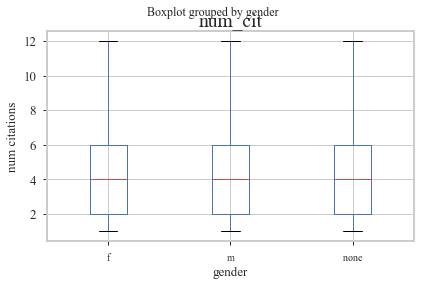

In [33]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer respectively
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [34]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
print(authorCitationsData.head(10))

('authorCitationsData before filtering', 176097)
(32, ' rows were present')
('authorCitationsData after filtering', 176065)
   year             author  num_cit  start_year  end_year  total_num_pub  \
0  1970    albert r. meyer        2        1970      2002             75   
1  1970      alfred v. aho        2        1970      2015             67   
2  1970   azriel rosenfeld        3        1970      2007            386   
3  1970    david f. martin        3        1970      2003             15   
4  1970      gerald estrin        3        1970      2002             17   
5  1970   james l. elshoff        2        1970      1991             11   
6  1970  jeffrey d. ullman        2        1970      2015            221   
7  1970  leonard kleinrock        4        1970      2014            112   
8  1970     paul t. hulina        2        1970      1999             23   
9  1970    robert f. rosin        2        1970      1992              9   

   career_length gender  
0            

### Cohort Analysis on all authors for 15 years

In [35]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

       year            author  num_cit  start_year  end_year  total_num_pub  \
7990   1995  donatella sciuto       30        1985      2016            348   
11331  1997  donatella sciuto      212        1985      2016            348   
13728  1998  donatella sciuto       44        1985      2016            348   
16628  1999  donatella sciuto      275        1985      2016            348   
20631  2000  donatella sciuto       32        1985      2016            348   
25326  2001  donatella sciuto       36        1985      2016            348   
37806  2003  donatella sciuto      116        1985      2016            348   
44062  2004  donatella sciuto      609        1985      2016            348   
51524  2005  donatella sciuto      353        1985      2016            348   
61681  2006  donatella sciuto      209        1985      2016            348   

       career_length gender  
7990              31      f  
11331             31      f  
13728             31      f  
16628     

In [36]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
   cohort_start_year  cohort_size  year      gini  career_age
0               1970         2139  1970  0.120192           0
1               1970         2139  1971  0.174242           1
2               1970         2139  1972  0.331309           2
3               1970         2139  1973  0.238636           3
4               1970         2139  1974  0.401220           4


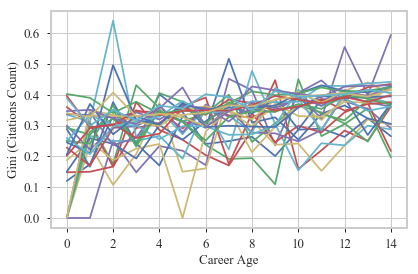

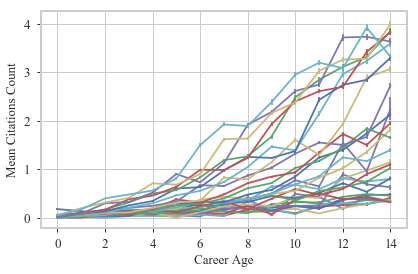

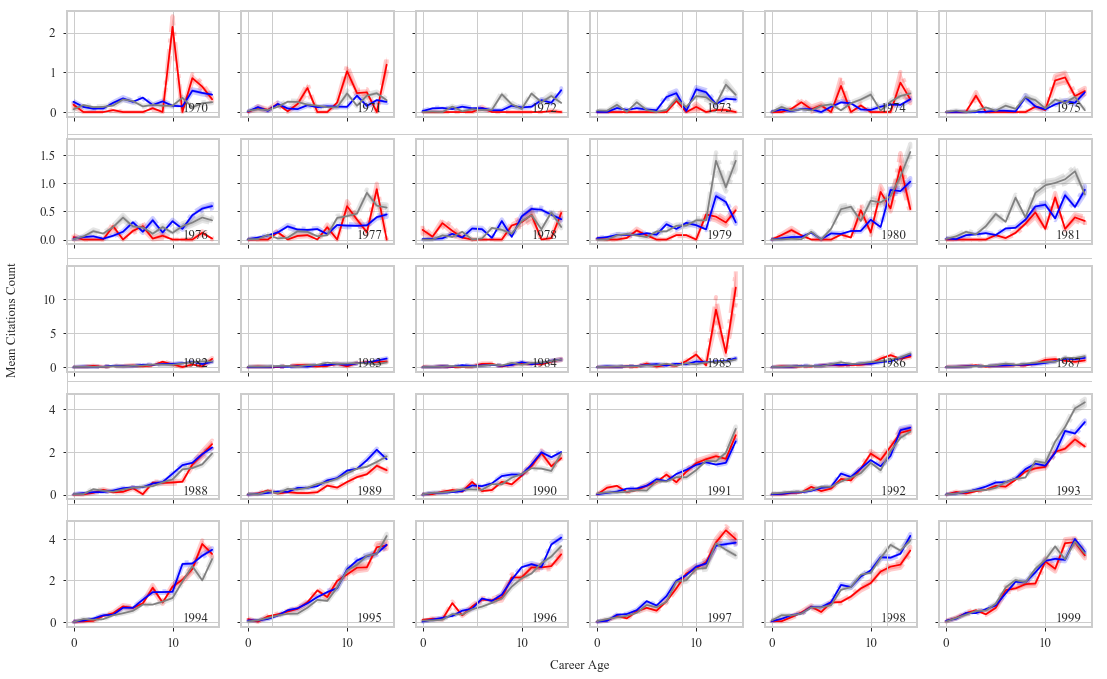

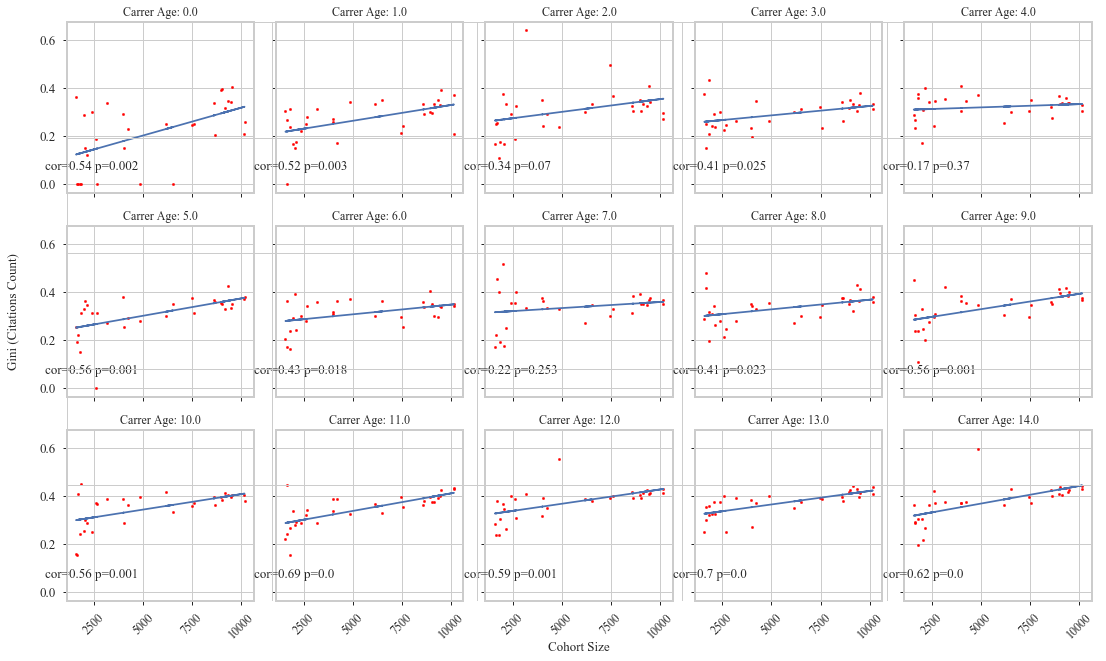

In [37]:
#print(plt.style.available)

#just for debugging
#reload(plot)
#reload(calculate)
plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
   cohort_start_year  cohort_size  year      gini  career_age
0               1970         2139  1970  0.120192           0
1               1970         2139  1971  0.215714           1
2               1970         2139  1972  0.351198           2
3               1970         2139  1973  0.378378           3
4               1970         2139  1974  0.422757           4


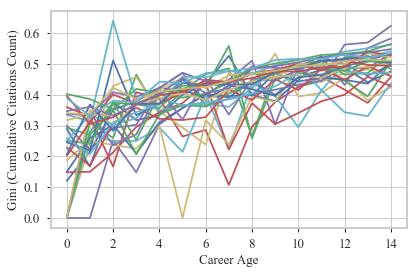

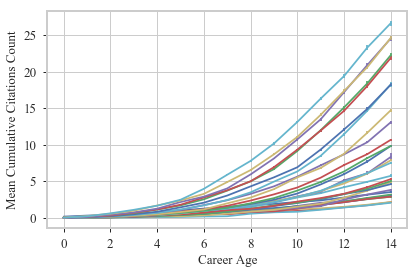

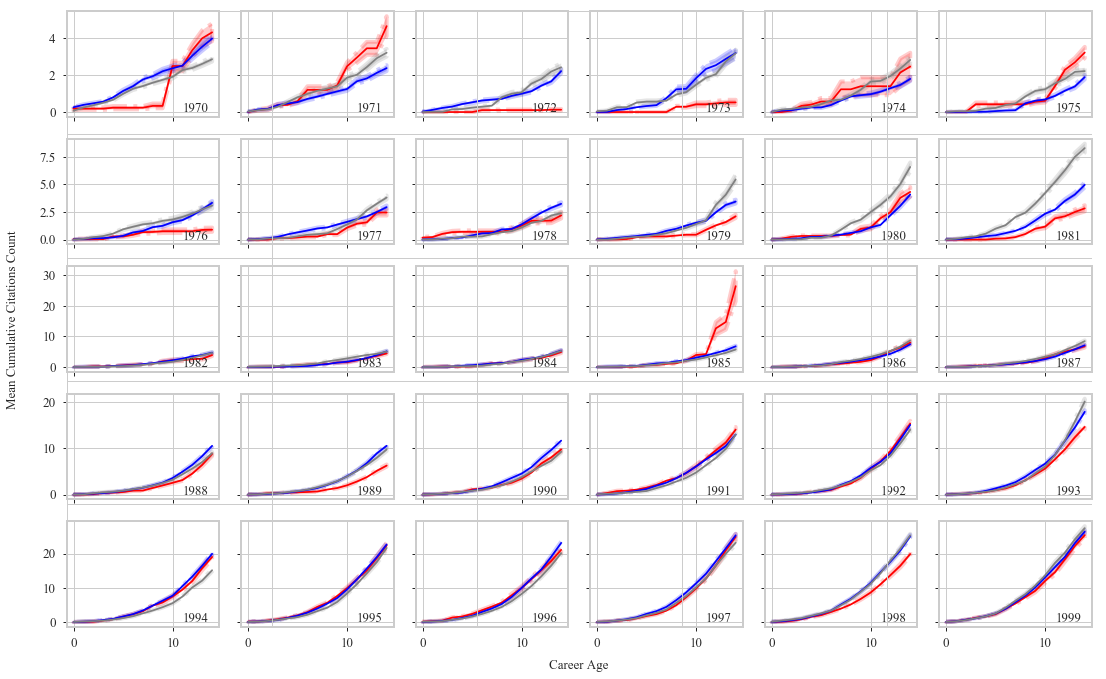

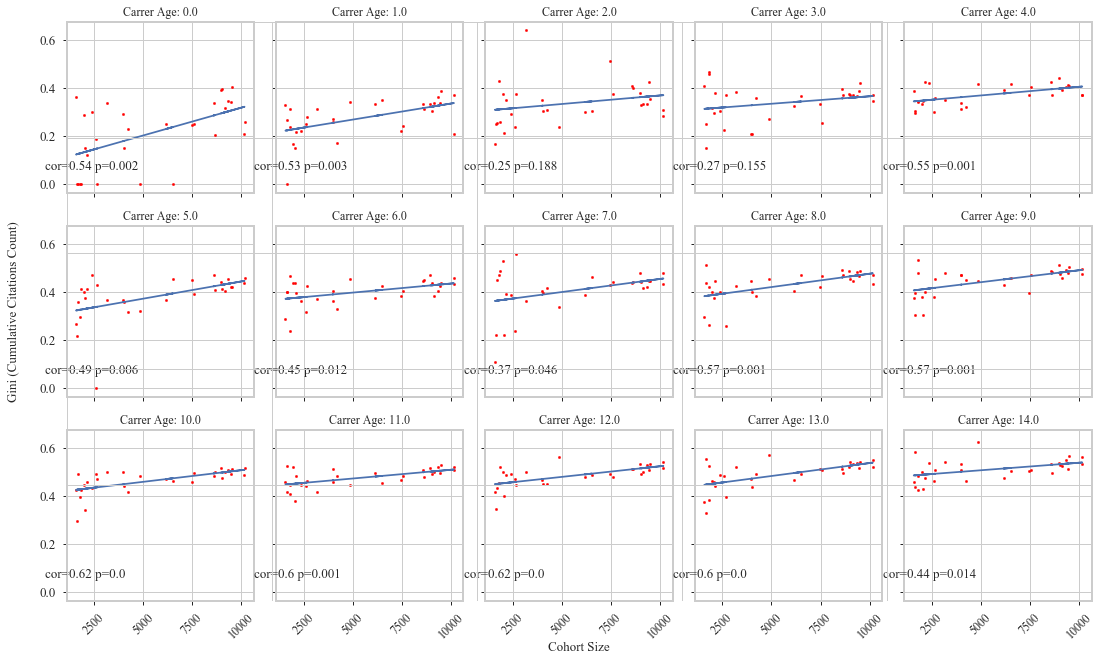

In [38]:
#just for debugging
#reload(plot)
#reload(calculate)
plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')

Why is there a sudden increase in mean citation count for cohort started in 1985?

In [39]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

(4851, 8)

In [40]:
_1985Authors.columns

Index([u'year', u'author', u'num_cit', u'start_year', u'end_year',
       u'total_num_pub', u'career_length', u'gender'],
      dtype='object')

In [41]:
_1985Authors.sort(columns=['num_cit'], axis = 0, ascending=False,inplace=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
167063,2014,donatella sciuto,26600,1985,2016,348,31,f
174925,2015,donatella sciuto,11694,1985,2016,348,31,f
154382,2013,donatella sciuto,5641,1985,2016,348,31,f
139701,2012,donatella sciuto,1580,1985,2016,348,31,f
96513,2009,donatella sciuto,652,1985,2016,348,31,f
44062,2004,donatella sciuto,609,1985,2016,348,31,f
72454,2007,donatella sciuto,589,1985,2016,348,31,f
110856,2010,donatella sciuto,531,1985,2016,348,31,f
51524,2005,donatella sciuto,353,1985,2016,348,31,f
16628,1999,donatella sciuto,275,1985,2016,348,31,f


In [46]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

(1027, 8)


,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
1375,1985,eiji okamoto,2,1985,2016,189,31,m
1503,1986,anas mahmoud,2,1985,2015,22,30,m
1585,1986,hideo shimazu,5,1985,2010,29,25,m
1613,1986,john hershberger,2,1985,2016,116,31,none
1619,1986,keith e. williamson,3,1985,2001,9,16,m
1627,1986,l. paul chew,1,1985,2009,40,24,m
1654,1986,michael shebanow,8,1985,2013,9,28,m
1657,1986,michel dagenais,1,1985,2015,39,30,m
1659,1986,nan niu,2,1985,2015,57,30,none
1683,1986,randolph g. bias,3,1985,2015,23,30,m


In [47]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

,year,author,num_cit
762,1999,donatella sciuto,275
542,1997,donatella sciuto,212
645,1998,donatella sciuto,44
988,2000,peter van den besselaar,33
912,2000,donatella sciuto,32


In [50]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

,year,author,num_cit,start_year,end_year,total_num_pub,career_length,gender
7990,1995,donatella sciuto,30,1985,2016,348,31,f
11331,1997,donatella sciuto,212,1985,2016,348,31,f
13728,1998,donatella sciuto,44,1985,2016,348,31,f
16628,1999,donatella sciuto,275,1985,2016,348,31,f
20631,2000,donatella sciuto,32,1985,2016,348,31,f
25326,2001,donatella sciuto,36,1985,2016,348,31,f
37806,2003,donatella sciuto,116,1985,2016,348,31,f
44062,2004,donatella sciuto,609,1985,2016,348,31,f
51524,2005,donatella sciuto,353,1985,2016,348,31,f
61681,2006,donatella sciuto,209,1985,2016,348,31,f


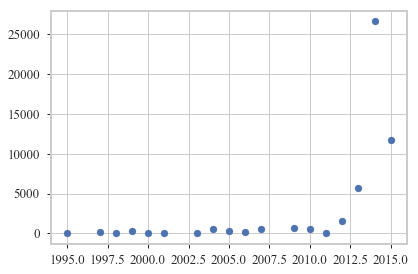

In [51]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [18]:
authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

,year,author,num_cit,start_year,end_year,pub_count,career_length,gender
7982,1995,donatella sciuto,30,1985.0,2016.0,345.0,31.0,f
11319,1997,donatella sciuto,212,1985.0,2016.0,345.0,31.0,f
13714,1998,donatella sciuto,44,1985.0,2016.0,345.0,31.0,f
16612,1999,donatella sciuto,275,1985.0,2016.0,345.0,31.0,f
20612,2000,donatella sciuto,32,1985.0,2016.0,345.0,31.0,f
25305,2001,donatella sciuto,36,1985.0,2016.0,345.0,31.0,f
37780,2003,donatella sciuto,116,1985.0,2016.0,345.0,31.0,f
44033,2004,donatella sciuto,609,1985.0,2016.0,345.0,31.0,f
51491,2005,donatella sciuto,353,1985.0,2016.0,345.0,31.0,f
61633,2006,donatella sciuto,209,1985.0,2016.0,345.0,31.0,f


## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

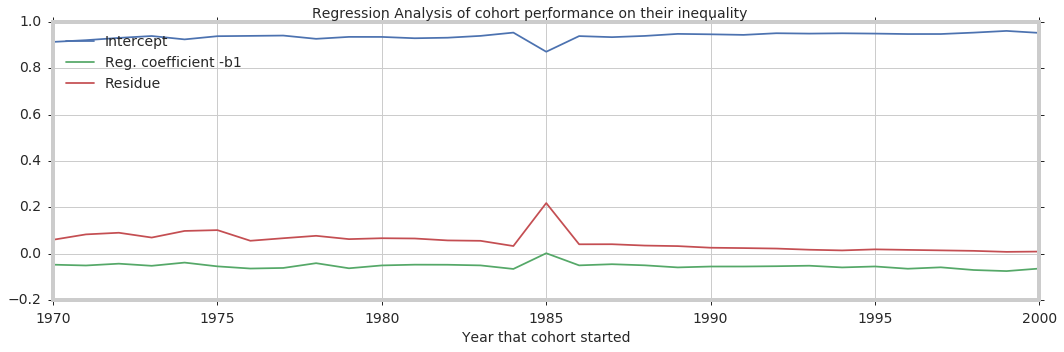

In [19]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

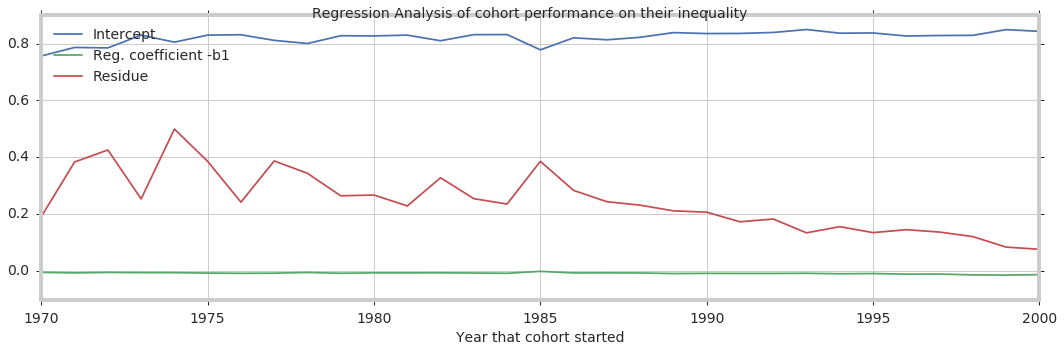

In [20]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

       year            author  num_cit  start_year  end_year  pub_count  \
7982   1995  donatella sciuto       30      1985.0    2016.0      345.0   
11319  1997  donatella sciuto      212      1985.0    2016.0      345.0   
13714  1998  donatella sciuto       44      1985.0    2016.0      345.0   
16612  1999  donatella sciuto      275      1985.0    2016.0      345.0   
20612  2000  donatella sciuto       32      1985.0    2016.0      345.0   
25305  2001  donatella sciuto       36      1985.0    2016.0      345.0   
37780  2003  donatella sciuto      116      1985.0    2016.0      345.0   
44033  2004  donatella sciuto      609      1985.0    2016.0      345.0   
51491  2005  donatella sciuto      353      1985.0    2016.0      345.0   
61633  2006  donatella sciuto      209      1985.0    2016.0      345.0   

       career_length gender  
7982            31.0      f  
11319           31.0      f  
13714           31.0      f  
16612           31.0      f  
20612           31.0    

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

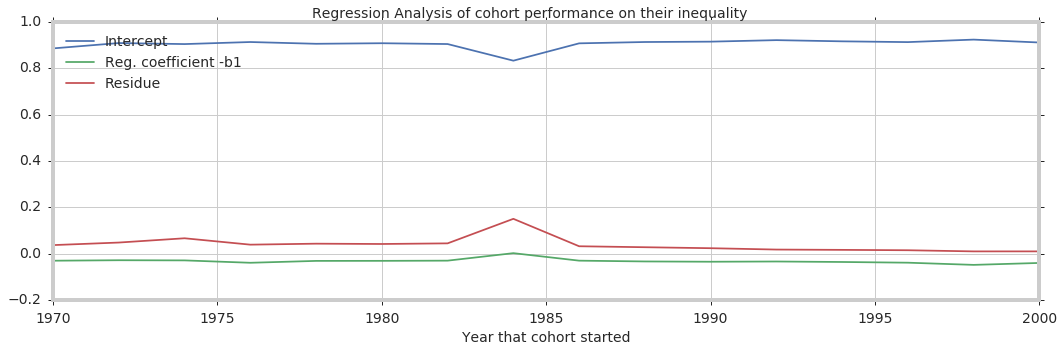

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

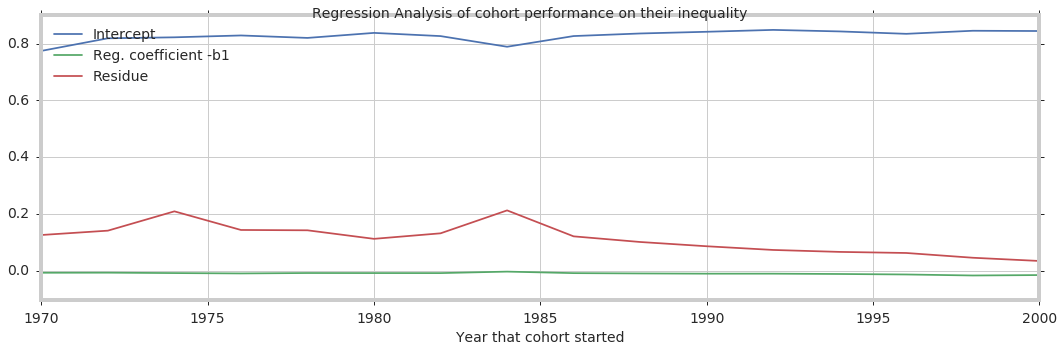

In [21]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

       year            author  num_cit  start_year  end_year  pub_count  \
7982   1995  donatella sciuto       30      1985.0    2016.0      345.0   
11319  1997  donatella sciuto      212      1985.0    2016.0      345.0   
13714  1998  donatella sciuto       44      1985.0    2016.0      345.0   
16612  1999  donatella sciuto      275      1985.0    2016.0      345.0   
20612  2000  donatella sciuto       32      1985.0    2016.0      345.0   
25305  2001  donatella sciuto       36      1985.0    2016.0      345.0   
37780  2003  donatella sciuto      116      1985.0    2016.0      345.0   
44033  2004  donatella sciuto      609      1985.0    2016.0      345.0   
51491  2005  donatella sciuto      353      1985.0    2016.0      345.0   
61633  2006  donatella sciuto      209      1985.0    2016.0      345.0   

       career_length gender  
7982            31.0      f  
11319           31.0      f  
13714           31.0      f  
16612           31.0      f  
20612           31.0    

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

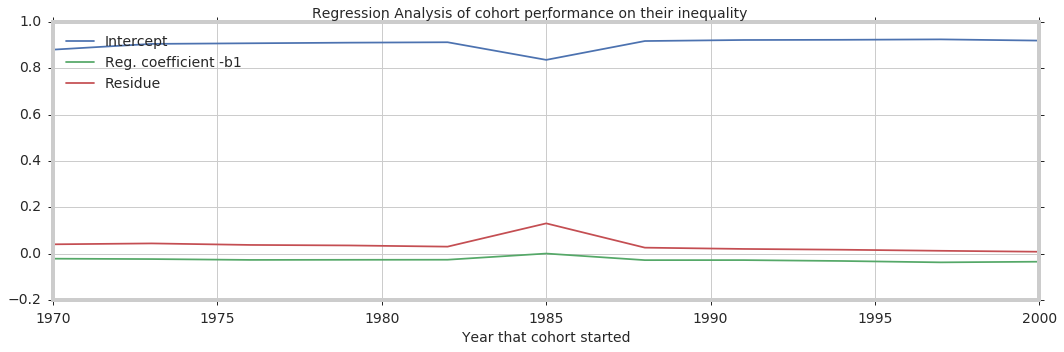

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

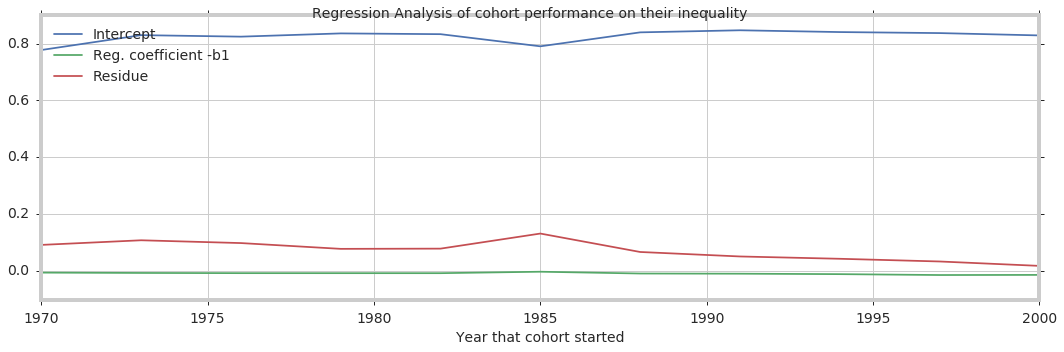

In [22]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)